In [ ]:
# clean up outputs from warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import scraper

category_titles = [
    "Category:Wikipedia_level-1_vital_articles",
    "Category:Wikipedia_level-2_vital_articles",
    "Category:Wikipedia_level-3_vital_articles",
    #"Category:Wikipedia_level-4_vital_articles",
    #"Category:Wikipedia_level-5_vital_articles"
]

page_graph, infos  = await scraper.scrape_wiki(category_titles)
nx.write_graphml(page_graph, "wikigraph.graphml")

In [ ]:
import os
import scraper
import re
import numpy as np
import networkx as nx
from tqdm.asyncio import tqdm

def parse_page(raw_content):
    # Normalize whitespace
    content = re.sub(r'[\n\t\ ]+', ' ', raw_content)

    # Retreive links to all pages
    all_links = np.unique(re.findall('\[([^/\]\[\|]+)[\]\|]', content))
    # Retreive links to User: pages
    user_links = np.unique(re.findall('\[(User:[^/\]\[\|]+)[\]\|]', content))
    # Retreive links to Talk: pages
    talk_links = np.unique(re.findall('\[((talk:|Talk:|User talk:|Wikipedia talk:)[^/\]\[\|]+)[\]\|]', content))
    article_links = [link for link in all_links if link not in user_links and link not in talk_links]
    return {"article": article_links, "user": user_links, "talk": talk_links}

def get_titles(filenames):
    return [fname[:-4] if fname[-4:] == ".txt" else fname for fname in filenames]

def parse_class(titles, dirpath):
    data = {}
    for title in titles:
        filepath = f"{dirpath}/{title}.txt"
        if os.path.isfile(filepath):
            with open(filepath, "r") as fh:
                content = fh.read()
                data[title] = parse_page(content)
        else:
            pass
    return data

def build_network_local():
    path = "./page_contents"
    talk_titles = get_titles(os.listdir(f"{path}/talks"))
    article_titles = get_titles(os.listdir(f"{path}/articles"))
    
    # Graph
    page_graph = nx.DiGraph()

    for talk_page_title in talk_titles:
        page_graph.add_node(talk_page_title, page_class="talk")
    for wiki_page_title in article_titles:
        page_graph.add_node(wiki_page_title, page_class="article")
        page_graph.add_edge(f"Talk:{wiki_page_title}", wiki_page_title)

        
    talk_data = parse_class(talk_titles, f"{path}/talks")
    articles_data = parse_class(article_titles, f"{path}/articles")

    link_types = ["article", "user", "talk"]

    count = 0
    disregarded = []
    # Add User: links to graph
    for title in tqdm(talk_data.keys(), desc="Adding talk page links"):
        page_data = talk_data[title]
        if page_data is not None and title in page_graph:
            for key in link_types:
                for link in page_data[key]:
                    if link not in page_graph:
                        page_graph.add_node(link, page_class=key)
                    page_graph.add_edge(link, title)
                    count += 1
        else:
            disregarded.append(title) # Talk:HIV for some reason
    # Add User: links to graph
    for title in tqdm(articles_data.keys(), desc="Adding article page links"):
        page_data = articles_data[title]
        if page_data is not None and title in page_graph:
            for key in link_types:
                for link in page_data[key]:
                    if link not in page_graph:
                        page_graph.add_node(link, page_class=key)
                    page_graph.add_edge(link, title)
                    count += 1
        else:
            disregarded.append(title)

    print("Total edges: " + str(count))
    print(f"Disregarded nodes: {len(disregarded)}")
    return page_graph

graph = build_network_local()

In [ ]:
nx.write_graphml(graph, "page_graph.graphml")

In [49]:
import networkx as nx
graph = nx.read_graphml("wikigraph.graphml")
# remove bots
bot_names = ["User:Community Tech bot", "User:PrimeBOT", "User:InternetArchiveBot", "User:AnomieBOT", "User:RMCD bot", "User:Cyberbot II", "User:CommonsNotificationBot",
"User:LinkBot", "User:FairuseBot", "User:BetacommandBot", "User:Legobot", "User:DumZiBoT"]
graph.remove_nodes_from(bot_names)


## Basic statistics

In [43]:
import pandas as pd

def largest_weakly_connected_c(graph):
     # extract largest weakly connected component
    connected_subgraphs = [graph.subgraph(c).copy() for c in nx.weakly_connected_components(graph)]
    max_conn_subgraph_index = np.argmax([len(graph) for graph in connected_subgraphs])
    return connected_subgraphs[max_conn_subgraph_index]

def top_n_by_degree(degree_dict, n):
    stat_view = pd.DataFrame(degree_dict, columns=["Node", "Degree"]).set_index("Node")
    return stat_view.sort_values(["Degree"], ascending=False).head(n)

def basic_stats(graph, top_n):
    G_biggest_comp = largest_weakly_connected_c(graph)

    # Create degree statistics
    degree_stats = top_n_by_degree(G_biggest_comp.degree, top_n)
    in_degree_stats = top_n_by_degree(G_biggest_comp.in_degree, top_n)
    out_degree_stats = top_n_by_degree(G_biggest_comp.out_degree, top_n)

    stats = {"degree": degree_stats, "in_degree": in_degree_stats, "out_degree": out_degree_stats}
    return G_biggest_comp, stats

In [76]:
# Analyse only users and talk pages
edits_filter = type_grouping["talk"] + type_grouping["user"]
G_edits = graph.subgraph(edits_filter)

edits_c, stats  = basic_stats(graph, 5)
print(f"Number of nodes: {edits_c.number_of_nodes()}")
print(f"Number of edges: {edits_c.number_of_edges()}")
print("Top 5 nodes by overall degree")
stats["degree"]

Number of nodes: 81575
Number of edges: 160037
Top 5 nodes by overall degree


,Degree
Node,
Talk:United States,2222
Talk:Jesus,1880
Talk:Climate change,1768
Talk:Israel,1612
Talk:India,1602


In [77]:
print("Top 5 nodes by in degree")
stats["in_degree"]

Top 5 nodes by in degree


,Degree
Node,
Talk:United States,2221
Talk:Jesus,1879
Talk:Climate change,1767
Talk:Israel,1611
Talk:India,1601


In [78]:
print("Top 5 nodes by out degree")
stats["out_degree"]

Top 5 nodes by out degree


,Degree
Node,
User:ScottishFinnishRadish,235
User:Arjayay,215
User:Cannolis,206
User:Deacon Vorbis,138
User:Kuyabribri,138


## Community analysis

### Edits and editors subgraph

In [80]:
G_undirected = G_edits.to_undirected()
G_undirected.remove_nodes_from([node for node in G_undirected.nodes if G_undirected.degree(node) < 1])

louvain_partition = nx.community.louvain_communities(G_undirected)

print( "number of communities found: ", len(louvain_partition))
print("modularity of louvain partitions: ", nx.community.modularity(G_undirected, louvain_partition))

number of communities found:  47
modularity of louvain partitions:  0.5512134926177301


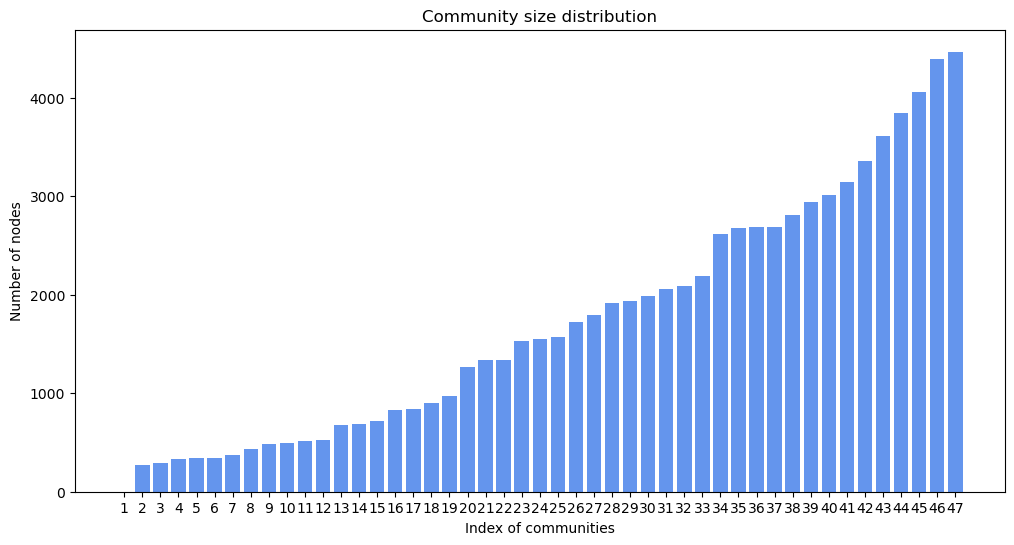

Size of each community printed:  [2, 274, 296, 327, 339, 345, 374, 429, 489, 499, 514, 524, 678, 684, 713, 827, 843, 903, 971, 1261, 1332, 1335, 1530, 1551, 1567, 1725, 1794, 1918, 1935, 1983, 2053, 2090, 2189, 2616, 2672, 2682, 2682, 2809, 2936, 3011, 3146, 3361, 3605, 3846, 4058, 4395, 4465]


In [81]:
sorted_size_communities = sorted([len(comm) for comm in louvain_partition])

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(
    [x for x in range(1,len(louvain_partition)+1)], 
    sorted_size_communities,
    color="cornflowerblue"
)
ax.set_title(label="Community size distribution")
ax.set_xlabel(xlabel="Index of communities")
ax.set_ylabel(ylabel="Number of nodes")
ax.set_xticks([x for x in range (1,len(louvain_partition)+1)])
ax.set_yticks([i for i in range (0, sorted_size_communities[-1], 1000)])
plt.show()

print("Size of each community printed: ", sorted_size_communities)

In [82]:
def create_grouping(undirected_graph, data_key):
    nodes_with_grouping = dict(undirected_graph.nodes(data=data_key))
    classes = set(nodes_with_grouping.values())
    grouping =  {}
    for type in classes:
        grouping[type] = list(filter(lambda key: nodes_with_grouping[key] == type, nodes_with_grouping))
    return grouping

In [83]:
type_grouping = create_grouping(G_undirected, "page_class")
type_partition_modularity = nx.community.modularity(G_undirected, type_grouping.values())
print("Type partition modularity:", type_partition_modularity)

Type partition modularity: -0.5


In [103]:
G_talks = G_undirected.subgraph(type_grouping["talk"])
G_users = G_undirected.subgraph(type_grouping["user"])
print(f"Connections between talk pages: {G_talks.number_of_edges()}")
print(f"Connections between user pages: {G_users.number_of_edges()}")

Connections between talk pages: 0
Connections between user pages: 0


In [132]:
talks_sub = nx.Graph()

for page in type_grouping["talk"][:1]:
    editors = set(G_undirected.neighbors(page))
    related = {}
    for user in editors:
        r_user = G_undirected.neighbors(user)
        for talk in r_user:
            if talk != page:
                if talk in related:
                    related[talk] += 1
                else:
                    related[talk] = 1
    talks_sub.add_weighted_edges_from([(page, r, related[r]) for r in related])


NameError: name 'labels' is not defined

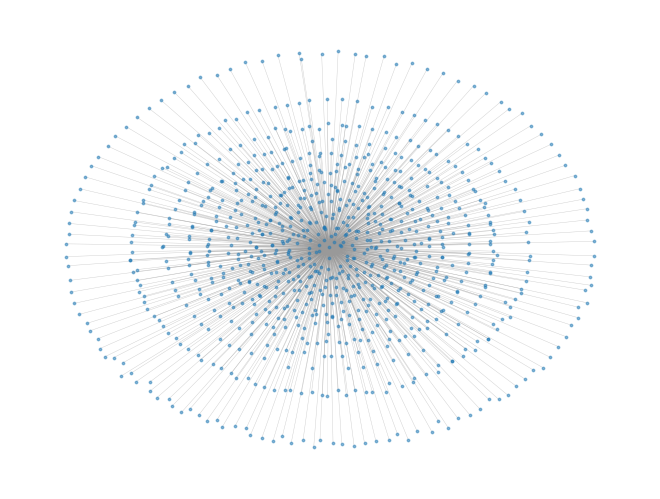

In [141]:
pos = nx.spring_layout(talks_sub)
label_pos = {node: (pos[node][0], pos[node][1] + 0.15) for node in talks_sub.nodes}
nx.draw(talks_sub, pos=pos, node_size=3, edge_color="#999999", width=0.3, alpha=0.5, with_labels=False)
nx.draw_networkx_labels(talks_sub, pos, labels=labels, font_size=10, font_color='black')
plt.show()